In [18]:
import os
import json
import numpy as np
from openai import AzureOpenAI
from sklearn.cluster import HDBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
#import umap
import umap.umap_ as umap
from dotenv import load_dotenv
load_dotenv(dotenv_path='openai_keys.env')


/Users/oshindutta/Documents/GitHub/anaconda3/envs/agent_search/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [13]:
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT_EMBEDDINGS")
)

DEPLOYMENT_NAME = os.getenv("AZURE_DEPLOYMENT_NAME_EMBEDDINGS")
print(DEPLOYMENT_NAME)

test-embedding-ada-002


In [14]:
with open("agent_duplicate.json", "r") as f:
    agent_cards = json.load(f)

def flatten_agent(agent):
    parts = [agent["name"], agent["description"], " ".join(agent["capabilities"])]
    for skill in agent.get("skills", []):
        parts.extend([
            skill["name"], 
            skill["description"], 
            " ".join(skill["tags"]), 
            " ".join(skill["examples"])
        ])
    return " ".join(parts)

In [15]:
def embed_text(text):
    resp = client.embeddings.create(
        model=DEPLOYMENT_NAME,  
        input=text
    )
    return resp.data[0].embedding

agent_texts = [flatten_agent(a) for a in agent_cards]
agent_embeddings = np.array([embed_text(txt) for txt in agent_texts])
print(agent_texts)
print(agent_embeddings)
print("embed shape=",agent_embeddings.shape)



['ESG Agent Helps with providing actionable strategies to improve ESG performance recommendations analysis ESG Improvement Advisor Helps with providing actionable strategies to improve ESG performance ESG Improvement Based on the ESG risk report, what are the top three recommendations for improvement?', 'Risk Profiler Agent Analyzes business operations and generates risk profiles based on industry and geography. risk_assessment data_analysis Risk Analysis Advisor Generates a detailed risk profile from given operational data. Risk Management Business Intelligence Generate a risk profile for a manufacturing company in Southeast Asia.', 'Carbon Footprint Tracker Estimates and tracks carbon footprint for organizations or supply chains. carbon_estimation tracking Carbon Footprint Calculator Calculates estimated CO2 emissions based on provided activity data. Sustainability Climate Action Calculate carbon footprint from energy usage data of the past quarter.', 'Supply Chain Auditor Performs a

In [59]:
# reducer = umap.UMAP(n_neighbors=5, n_components=20, metric='cosine', random_state=42)
# reduced_embeddings = reducer.fit_transform(agent_embeddings)

reducer = umap.UMAP(n_components=15,n_neighbors=8, min_dist=0.1,metric='cosine', random_state=42)#n_components=15,
embedding_2d = reducer.fit_transform(agent_embeddings)
print('upmaped embeds=', embedding_2d.shape)

clusterer = HDBSCAN(min_cluster_size=2,min_samples=2, metric="cosine")
labels = clusterer.fit_predict(embedding_2d) #agent_embeddings)
print("labels=", labels)
for i, agent in enumerate(agent_cards):
    agent["cluster"] = int(labels[i])

upmaped embeds= (20, 15)
labels= [1 1 2 0 1 3 0 0 3 0 2 2 2 2 2 0 0 0 0 0]


/Users/oshindutta/Documents/GitHub/anaconda3/envs/agent_search/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [62]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=10)
X = vectorizer.fit_transform(agent_texts)
terms = vectorizer.get_feature_names_out()
print('feature names=',terms)

cluster_keywords = {}
for cluster_id in set(labels):
    print('cluster id=',cluster_id)
    if cluster_id == -1:  
        continue
    idxs = [i for i, lbl in enumerate(labels) if lbl == cluster_id]
    print("idx=", idxs)
    cluster_docs = X[idxs].toarray().sum(axis=0)
    top_idxs = cluster_docs.argsort()[::-1][:5]
    cluster_keywords[cluster_id] = [terms[i] for i in top_idxs]

print('cluster_keywords=',cluster_keywords)

feature names= ['advisor' 'compliance' 'data' 'energy' 'esg' 'risk' 'supplier' 'supply'
 'sustainability' 'waste']
cluster id= 0
idx= [3, 6, 7, 9, 15, 16, 17, 18, 19]
cluster id= 1
idx= [0, 1, 4]
cluster id= 2
idx= [2, 10, 11, 12, 13, 14]
cluster id= 3
idx= [5, 8]
cluster_keywords= {np.int64(0): ['compliance', 'esg', 'supplier', 'supply', 'data'], np.int64(1): ['risk', 'advisor', 'esg', 'data', 'waste'], np.int64(2): ['sustainability', 'energy', 'waste', 'advisor', 'data'], np.int64(3): ['data', 'energy', 'waste', 'sustainability', 'supply']}


In [63]:
def handle_query(query, top_k=3):
    query_emb = embed_text(query)

    if len(set(labels)) <= 1:
        sims = cosine_similarity([query_emb], agent_embeddings)[0]
        ranked = np.argsort(sims)[::-1][:top_k]
        return -1, ["global"], [(agent_cards[i], sims[i]) for i in ranked]

    cluster_centers = {}
    for cluster_id in set(labels):
        if cluster_id == -1:
            continue
        idxs = [i for i, lbl in enumerate(labels) if lbl == cluster_id]
        cluster_centers[cluster_id] = np.mean(agent_embeddings[idxs], axis=0)

    sims = {cid: cosine_similarity([query_emb], [emb])[0][0]
            for cid, emb in cluster_centers.items()}
    best_cluster = max(sims, key=sims.get)

    idxs = [i for i, lbl in enumerate(labels) if lbl == best_cluster]
    sims_agents = cosine_similarity([query_emb], agent_embeddings[idxs])[0]
    ranked = np.argsort(sims_agents)[::-1][:top_k]
    results = [(agent_cards[idxs[i]], sims_agents[i]) for i in ranked]
    return best_cluster, cluster_keywords.get(best_cluster, []), results

In [64]:
query = "Can the risk be reduced for the company products?" #"Can you provide ESG improvement recommendations?"
cluster_id, keywords, results = handle_query(query)

print(f"Query routed to cluster {cluster_id} | Keywords: {keywords}\n")
for agent, score in results:
    print(f"Agent: {agent['name']} | Score: {score:.3f} | URL: {agent['url']}")

Query routed to cluster 1 | Keywords: ['risk', 'advisor', 'esg', 'data', 'waste']

Agent: Risk Profiler Agent | Score: 0.781 | URL: http://localhost:8001/
Agent: ESG Agent | Score: 0.761 | URL: http://localhost:8000/
Agent: Financial Advisor Bot | Score: 0.737 | URL: http://localhost:8004/


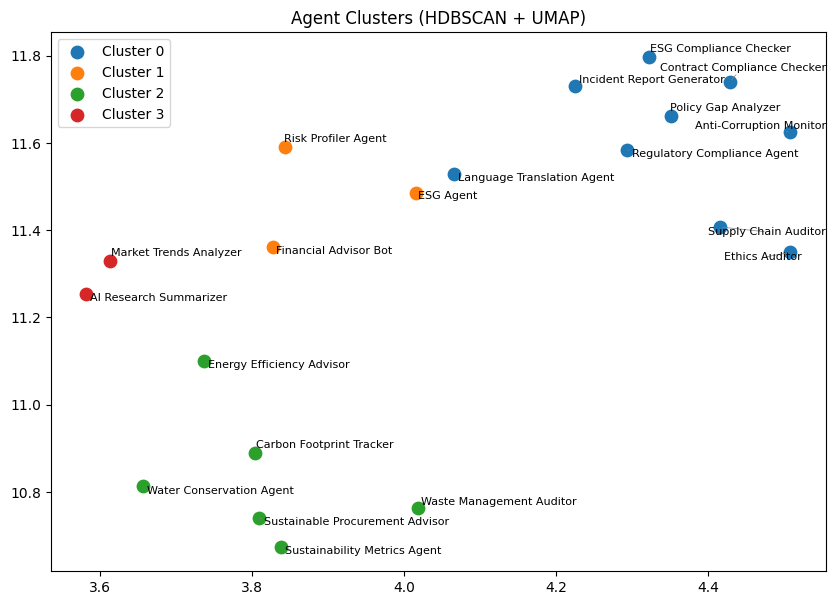

In [60]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
from adjustText import adjust_text
# reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
# embedding_2d = reducer.fit_transform(agent_embeddings)
# print(embedding_2d)

plt.figure(figsize=(10, 7))
for cluster_id in set(labels):
    mask = labels == cluster_id
    if cluster_id == -1:
        plt.scatter(
            embedding_2d[mask, 0], embedding_2d[mask, 1],
            color="lightgrey", label="Outliers", alpha=0.6, s=80
        )
    else:
        plt.scatter(
            embedding_2d[mask, 0], embedding_2d[mask, 1],
            label=f"Cluster {cluster_id}", s=80
        )
# Create a list to hold the text objects
texts = []
for i, agent in enumerate(agent_cards):
    # Note: I've removed the +0.02 offset, as adjustText handles positioning.
    texts.append(plt.text(
        embedding_2d[i, 0], embedding_2d[i, 1],
        agent["name"], fontsize=8
        )
    )
# Let the library automatically adjust the text positions
# The 'arrowprops' draws a line from the text to the point
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
plt.title("Agent Clusters (HDBSCAN + UMAP)")
plt.legend()
plt.show()
